In [1]:
#importing python modules and packages
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx
import proj as prj
import rasterio as rio
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterstats import zonal_stats
from rasterstats import gen_zonal_stats
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import xyzservices.providers as xyz
pd.set_option('display.max_columns', None)

In [2]:
#reading zipcode data with floodzone ratio
zipcode_FL = gpd.read_file('../data/Floodzones/zipcode_floodzoneratio.shp')
zipcode_FL.head()

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Shape_Leng,Shape_Area,1in100,1in500,geometry
0,34210,34210,B5,G6350,S,23017418.0,26292447.0,+27.4375477,-082.6301776,0.392643,0.004501,0.113379,0.222640,"POLYGON ((-82.60410 27.46737, -82.60410 27.467..."
1,33010,33010,B5,G6350,S,11192368.0,164233.0,+25.8332017,-080.2787199,0.199796,0.001022,0.258887,0.508645,"POLYGON ((-80.27856 25.85130, -80.27659 25.851..."
2,33919,33919,B5,G6350,S,22658042.0,6915450.0,+26.5558907,-081.9028554,0.261206,0.002679,0.150244,0.245144,"POLYGON ((-81.89077 26.59651, -81.89080 26.596..."
3,33461,33461,B5,G6350,S,18418467.0,1128555.0,+26.6185821,-080.0932157,0.240485,0.001772,0.243344,0.415006,"POLYGON ((-80.07217 26.63395, -80.06876 26.633..."
4,33605,33605,B5,G6350,S,20307052.0,3682174.0,+27.9510524,-082.4296347,0.291570,0.002193,0.134586,0.202821,"POLYGON ((-82.43571 27.90303, -82.43620 27.903..."


### Zillow Home Value Index

In [3]:
#reading and slicing florida for Zillow Home Value Index csv data
ZHVI = pd.read_csv('../data/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

#filtering florida
ZHVI = ZHVI[ZHVI['State'] == "FL"]
print (ZHVI.RegionID.nunique())
display (ZHVI.head())

927


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28
80,73221,80,34787,zip,FL,FL,Winter Garden,"Orlando-Kissimmee-Sanford, FL",Orange County,172048.805635,173031.292114,173844.579523,175281.051126,176267.979252,176779.429058,177198.518172,177812.560501,179117.109299,180678.584902,182037.737672,183061.558299,183814.685665,184323.005012,184791.416840,185475.019599,186252.590426,186933.763896,187283.118270,188035.630653,189224.159684,190674.243943,191885.031289,193029.099674,194329.178201,195692.434931,196990.682806,198111.341461,199428.305918,200626.140417,201707.513475,202957.020495,204104.849231,205537.859950,206938.203357,208256.312219,209255.769590,210037.593817,210898.944816,211958.380719,212757.021738,213809.730887,214881.900420,216431.783908,218146.646775,220093.443186,222072.640826,223904.244024,225807.732244,227848.383004,229823.304830,232221.419487,234782.355625,237829.690706,240844.367816,24467

In [4]:
#changing Zipcode information datatype to merge later
zipcode_FL['ZCTA5CE20'] = zipcode_FL['ZCTA5CE20'].astype(int)

#### Taking yearly average of home index values

In [5]:
#removing month and date from columns
for col in ZHVI.iloc[:, 9:].columns:
    ZHVI.rename(columns={col:col[0:4]},inplace=True)
print (ZHVI.columns)

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '2000',
       ...
       '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2023',
       '2023'],
      dtype='object', length=287)


In [6]:
# yearly mean calculation for year columns only
year_only =  ZHVI.iloc[:,9:]
yearly_mean = year_only.groupby(level=0,axis=1).mean()


In [7]:
# concating yearly mean with rest of zhvi columns
zhvi = pd.concat([(ZHVI.iloc[:, 0:8]),yearly_mean], axis =1)
#display (zhvi.head())                   

In [8]:
#merging zhvi with zip code boundaries of florida
df1_zhvi = zhvi.merge(zipcode_FL, left_on = 'RegionName', right_on = 'ZCTA5CE20')
print (df1_zhvi.RegionName.nunique())
df1_zhvi = gpd.GeoDataFrame(df1_zhvi, geometry = 'geometry')
df1_zhvi.head()

927


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Shape_Leng,Shape_Area,1in100,1in500,geometry
0,73221,80,34787,zip,FL,FL,Winter Garden,"Orlando-Kissimmee-Sanford, FL",177263.267129,187643.480413,201223.320205,215354.008392,240804.785914,301062.446501,383426.864196,379847.503394,312856.581220,237040.293736,207987.791511,192163.891302,194907.515570,225620.583412,265467.843769,284071.020341,301703.295696,317279.663610,336767.663471,362629.331745,384242.676969,441157.217430,546216.226622,553544.350791,34787,34787,B5,G6350,S,174167301.0,27808565.0,+28.4851744,-081.6194145,1.145243,0.018612,0.174195,0.219499,"MULTIPOLYGON (((-81.54431 28.52978, -81.54594 ..."
1,72362,96,33024,zip,FL,FL,Pembroke Pines,"Miami-Fort Lauderdale-Pompano Beach, FL",95537.304993,108702.206559,124185.919386,139790.268667,163857.909835,205683.131541,251764.265875,253794.935348,200817.126138,143575.945011,131565.666263,121491.664476,126801.369978,149960.265712,175041.638674,197509.653576,221028.288873,249445.718620,274301.429368,290352.267248,308487.613036,347410.141244,407862.981147,424388.837688,33024,33024,B5,G6350,S,30052050.0,738934.0,+26.0263576,-080.2446326,0.249723,0.002777,0.234319,0.422797,"POLYGON ((-80.21425 26.04301, -80.21424 26.042..."
2,72530,133,33311,zip,FL,FL,Fort Lauderdale,"Miami-Fort Lauderdale-Pompano Beach, FL",54515.456786,62814.582286,70907.582963,77471.104988,89831.197604,112318.043285,136781.857835,145739.291901,119516.244525,83129.706554,71682.686912,60706.506165,58555.923525,69627.607064,87321.086095,102459.049640,119528.897512,145298.003483,171881.436508,193133.086193,212828.248717,247273.325587,299024.079330,315607.724772,33311,33311,B5,G6350,S,26860151.0,449109.0,+26.1442083,-080.1727850,0.251871,0.002465,0.258111,0.433085,"POLYGON ((-80.14644 26.16659, -80.14644 26.166..."
3,72361,145,33023,zip,FL,FL,Miramar,"Miami-Fort Lauderdale-Pompano Beach, FL",80083.825376,90701.811936,103442.366702,115868.261262,135242.110348,167436.299937,204958.318773,215020.922953,176653.261455,126250.664213,111318.280962,101894.465529,101900.647392,120525.107732,143090.469411,162643.985334,187322.114906,219517.845182,249539.852448,268765.281952,289112.685012,327509.938242,382882.877666,398303.546514,33023,33023,B5,G6350,S,22801303.0,416222.0,+25.9884843,-080.2124621,0.239457,0.002093,0.234619,0.422255,"POLYGON ((-80.17512 25.99206, -80.17507 25.990..."
4,72578,149,33411,zip,FL,FL,NaN,"Miami-Fort Lauderdale-Pompano Beach, FL",121188.331699,131454.610877,147881.735614,170471.071814,203954.143763,257885.132880,307094.337425,284740.843805,228694.481712,183239.388321,166952.262721,152492.785203,148503.083351,170190.526392,203451.330663,226601.429539,252266.056058,272725.111759,291440.045873,303474.964079,317310.946182,365624.760036,440075.865111,447611.669489,33411,33411,B5,G6350,S,90267008.0,3511121.0,+26.7152013,-080.2037974,0.545057,0.008506,0.406732,0.582441,"POLYGON ((-80.13427 26.75174, -80.13430 26.750..."


In [9]:
#checking number of null values 
noPrice_2000 = df1_zhvi[df1_zhvi['2000'].isna()]
print (noPrice_2000.shape[0], " number of zip code have no price for the year 2000")

139  number of zip code have no price for the year 2000


In [10]:
# dropping null rows 
df1_zhvi.dropna(subset = '2000', inplace = True)

In [11]:
#percentage chnage from 2000 to february 2023
df1_zhvi['%Change'] = (df1_zhvi['2023'] - df1_zhvi['2000'])/df1_zhvi['2000']
df1_zhvi.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Shape_Leng,Shape_Area,1in100,1in500,geometry,%Change
0,73221,80,34787,zip,FL,FL,Winter Garden,"Orlando-Kissimmee-Sanford, FL",177263.267129,187643.480413,201223.320205,215354.008392,240804.785914,301062.446501,383426.864196,379847.503394,312856.581220,237040.293736,207987.791511,192163.891302,194907.515570,225620.583412,265467.843769,284071.020341,301703.295696,317279.663610,336767.663471,362629.331745,384242.676969,441157.217430,546216.226622,553544.350791,34787,34787,B5,G6350,S,174167301.0,27808565.0,+28.4851744,-081.6194145,1.145243,0.018612,0.174195,0.219499,"MULTIPOLYGON (((-81.54431 28.52978, -81.54594 ...",2.122725
1,72362,96,33024,zip,FL,FL,Pembroke Pines,"Miami-Fort Lauderdale-Pompano Beach, FL",95537.304993,108702.206559,124185.919386,139790.268667,163857.909835,205683.131541,251764.265875,253794.935348,200817.126138,143575.945011,131565.666263,121491.664476,126801.369978,149960.265712,175041.638674,197509.653576,221028.288873,249445.718620,274301.429368,290352.267248,308487.613036,347410.141244,407862.981147,424388.837688,33024,33024,B5,G6350,S,30052050.0,738934.0,+26.0263576,-080.2446326,0.249723,0.002777,0.234319,0.422797,"POLYGON ((-80.21425 26.04301, -80.21424 26.042...",3.442127
2,72530,133,33311,zip,FL,FL,Fort Lauderdale,"Miami-Fort Lauderdale-Pompano Beach, FL",54515.456786,62814.582286,70907.582963,77471.104988,89831.197604,112318.043285,136781.857835,145739.291901,119516.244525,83129.706554,71682.686912,60706.506165,58555.923525,69627.607064,87321.086095,102459.049640,119528.897512,145298.003483,171881.436508,193133.086193,212828.248717,247273.325587,299024.079330,315607.724772,33311,33311,B5,G6350,S,26860151.0,449109.0,+26.1442083,-080.1727850,0.251871,0.002465,0.258111,0.433085,"POLYGON ((-80.14644 26.16659, -80.14644 26.166...",4.789326
3,72361,145,33023,zip,FL,FL,Miramar,"Miami-Fort Lauderdale-Pompano Beach, FL",80083.825376,90701.811936,103442.366702,115868.261262,135242.110348,167436.299937,204958.318773,215020.922953,176653.261455,126250.664213,111318.280962,101894.465529,101900.647392,120525.107732,143090.469411,162643.985334,187322.114906,219517.845182,249539.852448,268765.281952,289112.685012,327509.938242,382882.877666,398303.546514,33023,33023,B5,G6350,S,22801303.0,416222.0,+25.9884843,-080.2124621,0.239457,0.002093,0.234619,0.422255,"POLYGON ((-80.17512 25.99206, -80.17507 25.990...",3.973583
4,72578,149,33411,zip,FL,FL,NaN,"Miami-Fort Lauderdale-Pompano Beach, FL",121188.331699,131454.610877,147881.735614,170471.071814,203954.143763,257885.132880,307094.337425,284740.843805,228694.481712,183239.388321,166952.262721,152492.785203,148503.083351,170190.526392,203451.330663,226601.429539,252266.056058,272725.111759,291440.045873,303474.964079,317310.946182,365624.760036,440075.865111,447611.669489,33411,33411,B5,G6350,S,90267008.0,3511121.0,+26.7152013,-080.2037974,0.545057,0.008506,0.406732,0.582441,"POLYGON ((-80.13427 26.75174, -80.13430 26.750...",2.693521


In [12]:
df1_zhvi.drop(columns = ['ZCTA5CE20', 'GEOID20', 'CLASSFP20', 'MTFCC20', 'FUNCSTAT20',
       'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20'], inplace = True)

In [13]:
df1_zhvi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
#changing epsg to NAD83 / Florida GDL Albers 3086
df1_zhvi = df1_zhvi.to_crs(epsg = 3086)

In [15]:
#df1_zhvi.crs

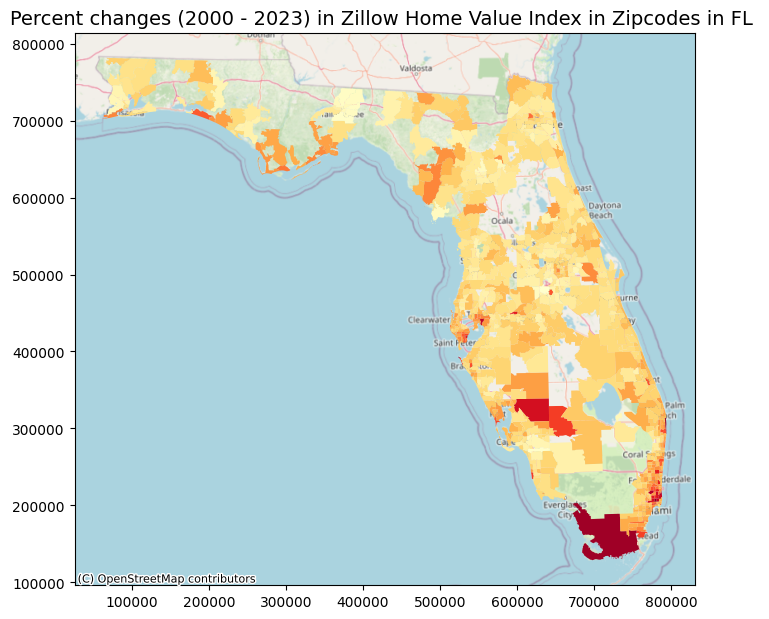

In [16]:
#plotting percent chnages
ax1 = df1_zhvi.plot(column = '%Change', cmap = 'YlOrRd', linewidth= 0, edgecolor='k', figsize=(8,8))
cx.add_basemap(ax1, source=xyz.OpenStreetMap.Mapnik, crs=df1_zhvi.crs)
ax1.set_title('Percent changes (2000 - 2023) in Zillow Home Value Index in Zipcodes in FL ',  fontdict={'fontsize': '14', 'fontweight' : '1'})
plt.savefig('../data/exportedMaps/ZHVI_percentChangeZipcode.pdf')

### Mapping nearest distance from coast to zipcode centroid

In [17]:
#creating new copy for df1_zhvi dataframe
df1_split = df1_zhvi.copy()
#calculating centroid of the polygons
df1_split['centroid'] = df1_zhvi['geometry'].centroid

df1_split.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Shape_Leng,Shape_Area,1in100,1in500,geometry,%Change,centroid
0,73221,80,34787,zip,FL,FL,Winter Garden,"Orlando-Kissimmee-Sanford, FL",177263.267129,187643.480413,201223.320205,215354.008392,240804.785914,301062.446501,383426.864196,379847.503394,312856.581220,237040.293736,207987.791511,192163.891302,194907.515570,225620.583412,265467.843769,284071.020341,301703.295696,317279.663610,336767.663471,362629.331745,384242.676969,441157.217430,546216.226622,553544.350791,1.145243,0.018612,0.174195,0.219499,"MULTIPOLYGON (((639845.336 505019.091, 639686....",2.122725,POINT (631739.906 499669.481)
1,72362,96,33024,zip,FL,FL,Pembroke Pines,"Miami-Fort Lauderdale-Pompano Beach, FL",95537.304993,108702.206559,124185.919386,139790.268667,163857.909835,205683.131541,251764.265875,253794.935348,200817.126138,143575.945011,131565.666263,121491.664476,126801.369978,149960.265712,175041.638674,197509.653576,221028.288873,249445.718620,274301.429368,290352.267248,308487.613036,347410.141244,407862.981147,424388.837688,0.249723,0.002777,0.234319,0.422797,"POLYGON ((778192.803 232326.980, 778194.403 23...",3.442127,POINT (775207.544 230237.772)
2,72530,133,33311,zip,FL,FL,Fort Lauderdale,"Miami-Fort Lauderdale-Pompano Beach, FL",54515.456786,62814.582286,70907.582963,77471.104988,89831.197604,112318.043285,136781.857835,145739.291901,119516.244525,83129.706554,71682.686912,60706.506165,58555.923525,69627.607064,87321.086095,102459.049640,119528.897512,145298.003483,171881.436508,193133.086193,212828.248717,247273.325587,299024.079330,315607.724772,0.251871,0.002465,0.258111,0.433085,"POLYGON ((784536.755 246245.190, 784537.439 24...",4.789326,POINT (781943.866 243670.222)
3,72361,145,33023,zip,FL,FL,Miramar,"Miami-Fort Lauderdale-Pompano Beach, FL",80083.825376,90701.811936,103442.366702,115868.261262,135242.110348,167436.299937,204958.318773,215020.922953,176653.261455,126250.664213,111318.280962,101894.465529,101900.647392,120525.107732,143090.469411,162643.985334,187322.114906,219517.845182,249539.852448,268765.281952,289112.685012,327509.938242,382882.877666,398303.546514,0.239457,0.002093,0.234619,0.422255,"POLYGON ((782275.929 226797.116, 782287.615 22...",3.973583,POINT (778539.582 226243.063)
4,72578,149,33411,zip,FL,FL,NaN,"Miami-Fort Lauderdale-Pompano Beach, FL",121188.331699,131454.610877,147881.735614,170471.071814,203954.143763,257885.132880,307094.337425,284740.843805,228694.481712,183239.388321,166952.262721,152492.785203,148503.083351,170190.526392,203451.330663,226601.429539,252266.056058,272725.111759,291440.045873,303474.964079,317310.946182,365624.760036,440075.865111,447611.669489,0.545057,0.008506,0.406732,0.582441,"POLYGON ((783714.960 311202.948, 783714.419 31...",2.693521,POINT (777014.572 306934.014)


In [18]:
#reading coastline shp into geodataframe
coastline = gpd.read_file('../data/tl_2022_us_coastline/tl_2022_us_coastline_epsg3086.shp')
display (coastline.head())
#print (coastline.geometry.crs)
print (coastline.shape)
#coastline.plot()

,NAME,MTFCC,geometry
0,Atlántico,L4150,"LINESTRING (2314644.768 -470812.051, 2314611.0..."
1,Gulf,L4150,"LINESTRING (-662077.698 671170.887, -662051.59..."
2,Gulf,L4150,"LINESTRING (281592.358 630663.792, 281632.754 ..."
3,Gulf,L4150,"LINESTRING (-298714.596 621005.621, -298688.34..."
4,Gulf,L4150,"LINESTRING (-719284.455 587719.003, -719289.84..."


(4236, 3)


#### joining centroid with nearest coastline

In [19]:
#creating series with centroid value only 
centroid = df1_split['centroid']

#dropping polygon geometry column to avoid duplicate geometry columns
df1_split.drop(columns =  ['geometry'], inplace = True)
df1_split.rename(columns = {'centroid': 'geometry'}, inplace = True)
df1_split.set_geometry(centroid, inplace = True)

In [20]:
#print (df1_split.shape)

In [21]:
#using sjoin_nearest to calculate nearest distance from centroid to coastline
zhvi_w_coastline = gpd.sjoin_nearest(df1_split, coastline, distance_col="distances")
print (zhvi_w_coastline.shape)
zhvi_w_coastline.head() 

(793, 42)


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Shape_Leng,Shape_Area,1in100,1in500,%Change,geometry,index_right,NAME,MTFCC,distances
0,73221,80,34787,zip,FL,FL,Winter Garden,"Orlando-Kissimmee-Sanford, FL",177263.267129,187643.480413,201223.320205,215354.008392,240804.785914,301062.446501,383426.864196,379847.503394,312856.581220,237040.293736,207987.791511,192163.891302,194907.515570,225620.583412,265467.843769,284071.020341,301703.295696,317279.663610,336767.663471,362629.331745,384242.676969,441157.217430,546216.226622,553544.350791,1.145243,0.018612,0.174195,0.219499,2.122725,POINT (631739.906 499669.481),1480,Atlantic,L4150,92775.538551
13,72199,290,32765,zip,FL,FL,Oviedo,"Orlando-Kissimmee-Sanford, FL",153007.349118,165235.512497,179530.946776,193677.771037,214029.278438,266929.988120,335926.865838,324193.634655,270023.796755,220471.001855,201467.121531,181670.044421,183466.185057,207831.282479,231500.769100,248249.532134,269355.177773,290120.437234,310512.933872,329049.820975,350563.471979,389411.161807,455171.829100,464779.415711,0.717521,0.010144,0.185232,0.232698,2.037628,POINT (673090.244 521004.969),1480,Atlantic,L4150,46424.660336
21,72234,407,32808,zip,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",62557.655687,66573.451811,69597.620490,73777.967300,82296.837708,100311.500064,127234.179224,132257.496235,111206.093076,77379.072632,57528.276572,48095.447164,47089.083138,55837.537165,69427.144539,76535.247030,92469.635315,112992.420213,138848.515899,157706.806686,172751.511144,199035.998034,241800.731122,248603.412068,0.302728,0.002996,0.089540,0.135043,2.973989,POINT (649585.109 510723.414),1480,Atlantic,L4150,71784.705234
23,72243,432,32818,zip,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",109594.065107,117076.241571,125650.734085,134545.296568,149378.774918,181624.046386,230051.253010,237312.963839,196535.343108,142146.198468,112916.113612,93753.423126,93399.254187,110701.306925,134113.988577,147103.354614,164012.508445,184522.066159,207287.040879,224473.369517,241007.692963,271832.609009,320461.171607,325583.968372,0.362490,0.002847,0.080605,0.098595,1.970818,POINT (645303.407 511284.358),1480,Atlantic,L4150,75100.926424
37,72203,565,32771,zip,FL,FL,Sanford,"Orlando-Kissimmee-Sanford, FL",109919.075603,116918.249074,124619.291802,135265.870301,150792.918141,190165.534871,240855.900462,238580.317895,200644.005577,155958.916408,131821.094342,114180.171486,112540.797030,128193.583480,146484.568009,158316.397884,172044.264839,191968.816551,211224.054498,224317.278180,242402.635776,280804.002825,339615.328232,349918.707723,0.676550,0.010741,0.180568,0.239965,2.183421,POINT (661307.248 537144.665),1480,Atlantic,L4150,47925.117763


In [22]:
duplicate = zhvi_w_coastline[zhvi_w_coastline.duplicated('RegionName')]
duplicated_regionname = duplicate['RegionName']
#zhvi_w_coastline[zhvi_w_coastline['RegionName'].isin(duplicated_regionname)]

In [23]:
#dropping duplicates 
zhvi_w_coastline.drop_duplicates(subset = 'distances', inplace = True)
print (zhvi_w_coastline.shape)
zhvi_w_coastline.head()

(788, 42)


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Shape_Leng,Shape_Area,1in100,1in500,%Change,geometry,index_right,NAME,MTFCC,distances
0,73221,80,34787,zip,FL,FL,Winter Garden,"Orlando-Kissimmee-Sanford, FL",177263.267129,187643.480413,201223.320205,215354.008392,240804.785914,301062.446501,383426.864196,379847.503394,312856.581220,237040.293736,207987.791511,192163.891302,194907.515570,225620.583412,265467.843769,284071.020341,301703.295696,317279.663610,336767.663471,362629.331745,384242.676969,441157.217430,546216.226622,553544.350791,1.145243,0.018612,0.174195,0.219499,2.122725,POINT (631739.906 499669.481),1480,Atlantic,L4150,92775.538551
13,72199,290,32765,zip,FL,FL,Oviedo,"Orlando-Kissimmee-Sanford, FL",153007.349118,165235.512497,179530.946776,193677.771037,214029.278438,266929.988120,335926.865838,324193.634655,270023.796755,220471.001855,201467.121531,181670.044421,183466.185057,207831.282479,231500.769100,248249.532134,269355.177773,290120.437234,310512.933872,329049.820975,350563.471979,389411.161807,455171.829100,464779.415711,0.717521,0.010144,0.185232,0.232698,2.037628,POINT (673090.244 521004.969),1480,Atlantic,L4150,46424.660336
21,72234,407,32808,zip,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",62557.655687,66573.451811,69597.620490,73777.967300,82296.837708,100311.500064,127234.179224,132257.496235,111206.093076,77379.072632,57528.276572,48095.447164,47089.083138,55837.537165,69427.144539,76535.247030,92469.635315,112992.420213,138848.515899,157706.806686,172751.511144,199035.998034,241800.731122,248603.412068,0.302728,0.002996,0.089540,0.135043,2.973989,POINT (649585.109 510723.414),1480,Atlantic,L4150,71784.705234
23,72243,432,32818,zip,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",109594.065107,117076.241571,125650.734085,134545.296568,149378.774918,181624.046386,230051.253010,237312.963839,196535.343108,142146.198468,112916.113612,93753.423126,93399.254187,110701.306925,134113.988577,147103.354614,164012.508445,184522.066159,207287.040879,224473.369517,241007.692963,271832.609009,320461.171607,325583.968372,0.362490,0.002847,0.080605,0.098595,1.970818,POINT (645303.407 511284.358),1480,Atlantic,L4150,75100.926424
37,72203,565,32771,zip,FL,FL,Sanford,"Orlando-Kissimmee-Sanford, FL",109919.075603,116918.249074,124619.291802,135265.870301,150792.918141,190165.534871,240855.900462,238580.317895,200644.005577,155958.916408,131821.094342,114180.171486,112540.797030,128193.583480,146484.568009,158316.397884,172044.264839,191968.816551,211224.054498,224317.278180,242402.635776,280804.002825,339615.328232,349918.707723,0.676550,0.010741,0.180568,0.239965,2.183421,POINT (661307.248 537144.665),1480,Atlantic,L4150,47925.117763


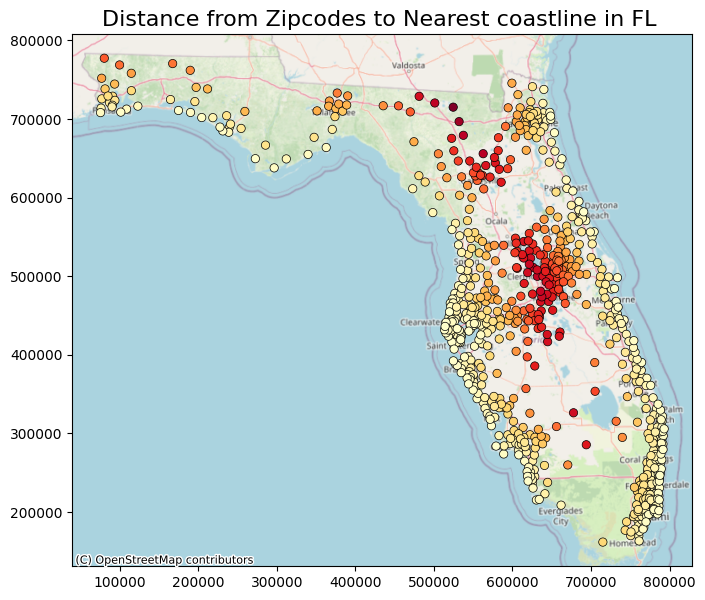

In [24]:
#plotting distance to coast from zipcode centroids
ax2 = zhvi_w_coastline.plot(column = 'distances', cmap = 'YlOrRd', linewidth= 0.5, edgecolor='k', figsize=(8,8))
cx.add_basemap(ax2, source=xyz.OpenStreetMap.Mapnik, crs=zhvi_w_coastline.crs)
ax2.set_title('Distance from Zipcodes to Nearest coastline in FL ',  fontdict={'fontsize': '16', 'fontweight' : '1'})
plt.savefig('../data/exportedMaps/ZHVI_distanceFromZipcodes.pdf')

## ZORI: Zillow Observed Rent Index

In [25]:
#reading rent index data
ZORI =  pd.read_csv('../data/Zip_zori_sm_month.csv')

#filtering florida
ZORI = ZORI[ZORI['State'] == "FL"]
print (ZORI.RegionName.nunique())
display (ZORI.head())

593


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28
74,73221,80,34787,zip,FL,FL,Winter Garden,"Orlando-Kissimmee-Sanford, FL",Orange County,1492.408033,1501.485999,1516.705404,1521.291216,1530.914612,1550.453499,1565.164421,1575.301229,1567.595865,1554.826953,1558.401344,1571.722397,1590.058947,1588.337488,1593.244482,1602.709047,1620.029722,1617.573997,1603.410788,1604.967875,1613.899891,1637.631409,1641.286170,1649.322715,1650.052748,1659.509315,1669.271882,1684.718078,1696.282187,1706.873305,1685.895763,1683.480136,1679.589857,1702.092731,1706.117767,1711.553002,1723.802607,1747.244678,1769.258618,1786.171479,1795.546253,1802.235541,1804.187759,1820.659993,1823.198345,1836.634178,1814.462003,1825.108080,1831.983042,1861.499619,1869.027847,1876.902456,1881.095323,1904.588294,1916.486375,1920.078371,1895.747460,1890.461522,1889.721813,1904.962678,1909.869794,1908.111588,1907.744640,1899.251666,1909.740701,1919.726414,1941.212545,1945.367667,1940.684815,1937.572417,1949.516208,1945.777528,1947.189160,1949.412406,1990.942552,2024.174878,2035.737643,2071.053514,2150.885658,2253.279145,2306.312193,2328.217625,2317.727117,2355.427044,2383.289032,2435.683055,2494.954121,2551.002252,2588.472147,2608.878319,2603.340137,2639.060698,2607.694156,2587.361006,2553.103797,2575.791604
89,72362,96,33024,zip,FL,FL,Pembroke Pines,"Miami-Fort Lauderdale-Pompano Beach, FL",Broward County,1424.431717,1429.506946,1425.318601,1430.138340,1443.112664,1451.039009,1414.901980,1421.007552,1427.415020,1487.000869,1492.577173,1496.694729,1487.865538,1490.157116,1513.635013,1561.263905,1570.062273,1560.590798,1517.781878,1513.116883,1522.990409,1529.371551,1540.231044,1533.458753,1545.182704,1544.722321,1562.063429,1571.501067,1584.571026,1578.228217,1585.569583,1575.331643,1586.113172,1578.283039,1592.243962,1591.539108,1606.093888,1614.755862,1626.761813,1625.184311,1610.643508,1612.213269,1606.806194,1615.163875,1621.838251,1619.916164,1640.599693,1642.149729,1652.627738,1646.575212,1655.049267,1674.034663,1687.279363,1678.791297,1669.764706,1661.958975,1649.117025,1660.818458,1661.861341,1683.639605,1702.233776,1704.787136,1696.223823,1678.456987,1697.138975,1718.203662,1708.763054,1703.237490,1706.265538,1738.132426,1753.214190,1745.033013,1776.236058,1805.986589,NaN,1955.239792,2002.893516,2033.002679,2042.148819,2060.242179,2072.113161,2091.021188,2118.994792,2040.799968,2162.452852,2292.147193,2478.516160,2480.461085,2454.340662,2495.750343,2513.463601,2538.147217,2494.210355,2473.717530,2475.624873,2544.565657
126,72530,133,33311,zip,FL,FL,Fort Lauderdale,"Miami-Fort Lauderdale-Pompano Beach, FL",Broward County,1226.934988,1233.914947,1252.488310,1247.632949,1233.720170,1226.976517,1235.685878,1254.075768,1267.542828,1264.180447,1275.561948,1280.529069,1306.362858,1319.554387,1326.538087,1310.610704,1310.105176,1313.375254,1339.938618,1349.627194,1375.209849,1336.469814,1341.304481,13

#### Taking yearly average of rent index

In [26]:
#removing month and date from columns
for col in ZORI.iloc[:, 9:].columns:
    ZORI.rename(columns={col:col[0:4]},inplace=True)
#print (ZORI.columns)

# yearly mean calculation for year columns only
year_only =  ZORI.iloc[:,9:]
yearly_mean = year_only.groupby(level=0,axis=1).mean()
# concating yearly mean with rest of zhvi columns
zori = pd.concat([(ZORI.iloc[:, 0:8]),yearly_mean], axis =1)
display (zori.head())

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2015,2016,2017,2018,2019,2020,2021,2022,2023
74,73221,80,34787,zip,FL,FL,Winter Garden,"Orlando-Kissimmee-Sanford, FL",1537.614723,1600.165615,1675.697907,1777.217518,1873.953366,1917.830561,2079.374876,2514.407424,2564.447701
89,72362,96,33024,zip,FL,FL,Pembroke Pines,"Miami-Fort Lauderdale-Pompano Beach, FL",1435.387270,1521.342272,1565.438000,1611.930017,1659.897177,1699.911984,1939.739199,2378.583480,2510.095265
126,72530,133,33311,zip,FL,FL,Fort Lauderdale,"Miami-Fort Lauderdale-Pompano Beach, FL",1244.315280,1320.323580,1404.216217,1491.743958,1559.527182,1625.727550,1804.131313,2171.908074,2309.459382
137,72361,145,33023,zip,FL,FL,Miramar,"Miami-Fort Lauderdale-Pompano Beach, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2413.985629,2611.594605
141,72578,149,33411,zip,FL,FL,NaN,"Miami-Fort Lauderdale-Pompano Beach, FL",1368.592329,1440.393261,1494.609841,1556.168048,1614.233356,1669.318636,1946.491215,2350.613168,2419.176351


In [27]:
#checking number of null values 
noPrice_2015 = zori[zori['2015'].isna()]
print (noPrice_2015.shape[0], " number of zip code have no price for the year 2015")

# dropping null rows 
zori.dropna(subset = '2015', inplace = True)

364  number of zip code have no price for the year 2015


In [28]:
# dropping null rows 
zori.dropna(how = 'all', inplace = True)
zori.shape

(229, 17)

In [29]:
#merging zhvi with zip code boundaries of florida
df1_zori = zori.merge(zipcode_FL, left_on = 'RegionName', right_on = 'ZCTA5CE20')
print (df1_zori.RegionName.nunique())
df1_zori = gpd.GeoDataFrame(df1_zori, geometry = 'geometry')
df1_zori.head()

229


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2015,2016,2017,2018,2019,2020,2021,2022,2023,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Shape_Leng,Shape_Area,1in100,1in500,geometry
0,73221,80,34787,zip,FL,FL,Winter Garden,"Orlando-Kissimmee-Sanford, FL",1537.614723,1600.165615,1675.697907,1777.217518,1873.953366,1917.830561,2079.374876,2514.407424,2564.447701,34787,34787,B5,G6350,S,174167301.0,27808565.0,+28.4851744,-081.6194145,1.145243,0.018612,0.174195,0.219499,"MULTIPOLYGON (((-81.54431 28.52978, -81.54594 ..."
1,72362,96,33024,zip,FL,FL,Pembroke Pines,"Miami-Fort Lauderdale-Pompano Beach, FL",1435.387270,1521.342272,1565.438000,1611.930017,1659.897177,1699.911984,1939.739199,2378.583480,2510.095265,33024,33024,B5,G6350,S,30052050.0,738934.0,+26.0263576,-080.2446326,0.249723,0.002777,0.234319,0.422797,"POLYGON ((-80.21425 26.04301, -80.21424 26.042..."
2,72530,133,33311,zip,FL,FL,Fort Lauderdale,"Miami-Fort Lauderdale-Pompano Beach, FL",1244.315280,1320.323580,1404.216217,1491.743958,1559.527182,1625.727550,1804.131313,2171.908074,2309.459382,33311,33311,B5,G6350,S,26860151.0,449109.0,+26.1442083,-080.1727850,0.251871,0.002465,0.258111,0.433085,"POLYGON ((-80.14644 26.16659, -80.14644 26.166..."
3,72578,149,33411,zip,FL,FL,NaN,"Miami-Fort Lauderdale-Pompano Beach, FL",1368.592329,1440.393261,1494.609841,1556.168048,1614.233356,1669.318636,1946.491215,2350.613168,2419.176351,33411,33411,B5,G6350,S,90267008.0,3511121.0,+26.7152013,-080.2037974,0.545057,0.008506,0.406732,0.582441,"POLYGON ((-80.13427 26.75174, -80.13430 26.750..."
4,72363,164,33025,zip,FL,FL,Miramar,"Miami-Fort Lauderdale-Pompano Beach, FL",1489.759680,1555.792017,1587.194869,1628.862643,1671.997643,1699.614308,1883.296125,2326.306764,2356.564713,33025,33025,B5,G6350,S,27326914.0,1317861.0,+25.9881829,-080.2813943,0.251369,0.002582,0.280269,0.507875,"POLYGON ((-80.24781 26.00149, -80.24776 26.000..."


In [30]:
#percentage chnage from 2015 to february 2023
df1_zori['percent_change'] = (df1_zori['2023'] - df1_zori['2015'])/df1_zori['2015']
df1_zori.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2015,2016,2017,2018,2019,2020,2021,2022,2023,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Shape_Leng,Shape_Area,1in100,1in500,geometry,percent_change
0,73221,80,34787,zip,FL,FL,Winter Garden,"Orlando-Kissimmee-Sanford, FL",1537.614723,1600.165615,1675.697907,1777.217518,1873.953366,1917.830561,2079.374876,2514.407424,2564.447701,34787,34787,B5,G6350,S,174167301.0,27808565.0,+28.4851744,-081.6194145,1.145243,0.018612,0.174195,0.219499,"MULTIPOLYGON (((-81.54431 28.52978, -81.54594 ...",0.667809
1,72362,96,33024,zip,FL,FL,Pembroke Pines,"Miami-Fort Lauderdale-Pompano Beach, FL",1435.387270,1521.342272,1565.438000,1611.930017,1659.897177,1699.911984,1939.739199,2378.583480,2510.095265,33024,33024,B5,G6350,S,30052050.0,738934.0,+26.0263576,-080.2446326,0.249723,0.002777,0.234319,0.422797,"POLYGON ((-80.21425 26.04301, -80.21424 26.042...",0.748723
2,72530,133,33311,zip,FL,FL,Fort Lauderdale,"Miami-Fort Lauderdale-Pompano Beach, FL",1244.315280,1320.323580,1404.216217,1491.743958,1559.527182,1625.727550,1804.131313,2171.908074,2309.459382,33311,33311,B5,G6350,S,26860151.0,449109.0,+26.1442083,-080.1727850,0.251871,0.002465,0.258111,0.433085,"POLYGON ((-80.14644 26.16659, -80.14644 26.166...",0.856008
3,72578,149,33411,zip,FL,FL,NaN,"Miami-Fort Lauderdale-Pompano Beach, FL",1368.592329,1440.393261,1494.609841,1556.168048,1614.233356,1669.318636,1946.491215,2350.613168,2419.176351,33411,33411,B5,G6350,S,90267008.0,3511121.0,+26.7152013,-080.2037974,0.545057,0.008506,0.406732,0.582441,"POLYGON ((-80.13427 26.75174, -80.13430 26.750...",0.767638
4,72363,164,33025,zip,FL,FL,Miramar,"Miami-Fort Lauderdale-Pompano Beach, FL",1489.759680,1555.792017,1587.194869,1628.862643,1671.997643,1699.614308,1883.296125,2326.306764,2356.564713,33025,33025,B5,G6350,S,27326914.0,1317861.0,+25.9881829,-080.2813943,0.251369,0.002582,0.280269,0.507875,"POLYGON ((-80.24781 26.00149, -80.24776 26.000...",0.581842


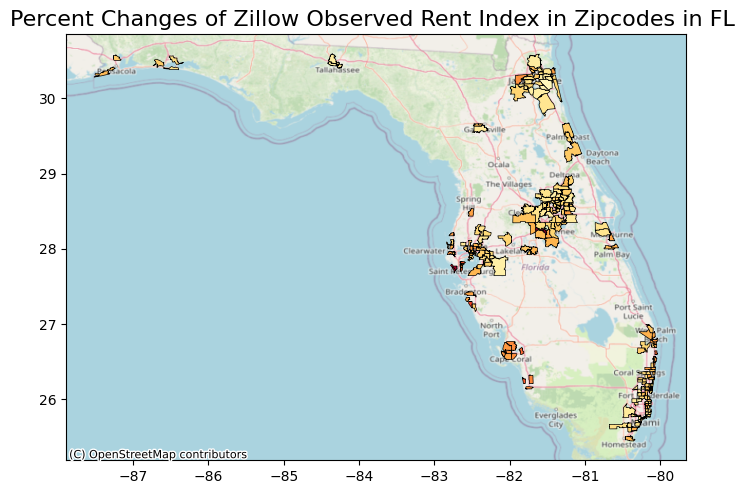

In [31]:
#plotting % chnages in rent index
ax3 = df1_zori.plot(column = 'percent_change', cmap = 'YlOrRd', linewidth= 0.5, edgecolor='k', figsize=(8,8))
cx.add_basemap(ax3, source=xyz.OpenStreetMap.Mapnik, crs=df1_zori.crs)
ax3.set_title('Percent Changes of Zillow Observed Rent Index in Zipcodes in FL ',  fontdict={'fontsize': '16', 'fontweight' : '1'})
plt.savefig('../data/exportedMaps/ZORI_percentChangeZipcodes.pdf')

### Calculating mean elevation in each zip code using DEM

#### resampling to make dem of 30 metre 

In [32]:
'''upscale_factor = (1/5.5218221989569685)

#Open the image using rio.open command as image
with rio.open("../data/FL_DEM/FL_DEM/flidar_mosaic_in.tif") as image:
    #Resample the data to target shape and provide the resampling technique (bilinear)

    data = image.read(
        out_shape=( image.count, int(image.height * upscale_factor), int(image.width * upscale_factor)),
        resampling=Resampling.bilinear) ##resampling as bilinear

    #Extract the transform information using transform and scale
    transform = image.transform * image.transform.scale(
        (image.width / data.shape[-1]),
        (image.height / data.shape[-2])
    )

    #Here, we will copy all the metadata
    kwargs = image.meta.copy()

    #Update the metadata with the updated scale factor and transform information
    kwargs.update({
    'transform': transform,
    'width': int(image.width * upscale_factor),
    'height': int(image.height * upscale_factor)
    })

#And we are all set to write the output image. After opening the file as result_image we will write the data into this.
with rio.open('../data/FL_DEM/FL_DEM/resampled_flidar_mosaic_in.tif', 'w', **kwargs) as result_image:
    result_image.write(data)'''

'upscale_factor = (1/5.5218221989569685)\n\n#Open the image using rio.open command as image\nwith rio.open("../data/FL_DEM/FL_DEM/flidar_mosaic_in.tif") as image:\n    #Resample the data to target shape and provide the resampling technique (bilinear)\n\n    data = image.read(\n        out_shape=( image.count, int(image.height * upscale_factor), int(image.width * upscale_factor)),\n        resampling=Resampling.bilinear) ##resampling as bilinear\n\n    #Extract the transform information using transform and scale\n    transform = image.transform * image.transform.scale(\n        (image.width / data.shape[-1]),\n        (image.height / data.shape[-2])\n    )\n\n    #Here, we will copy all the metadata\n    kwargs = image.meta.copy()\n\n    #Update the metadata with the updated scale factor and transform information\n    kwargs.update({\n    \'transform\': transform,\n    \'width\': int(image.width * upscale_factor),\n    \'height\': int(image.height * upscale_factor)\n    })\n\n#And we ar

In [33]:
'''#checking the cell size of original raster file
raster =  rio.open('../data/FL_DEM/FL_DEM/flidar_mosaic_in.tif')
gt = raster.transform
pixelSizeX = gt[0]
pixelSizeY =-gt[4]
print ('the resolution of original raster is,')
print (pixelSizeX, pixelSizeY)'''

"#checking the cell size of original raster file\nraster =  rio.open('../data/FL_DEM/FL_DEM/flidar_mosaic_in.tif')\ngt = raster.transform\npixelSizeX = gt[0]\npixelSizeY =-gt[4]\nprint ('the resolution of original raster is,')\nprint (pixelSizeX, pixelSizeY)"

In [34]:
'''#checking the cell size of resampled raster file
raster1 =  rio.open('../data/FL_DEM/FL_DEM/resampled_flidar_mosaic_in.tif')
gt = raster1.transform
pixelSizeX = gt[0]
pixelSizeY =-gt[4]
print ('the resolution of resampled raster is,')
print (pixelSizeX, pixelSizeY)'''

"#checking the cell size of resampled raster file\nraster1 =  rio.open('../data/FL_DEM/FL_DEM/resampled_flidar_mosaic_in.tif')\ngt = raster1.transform\npixelSizeX = gt[0]\npixelSizeY =-gt[4]\nprint ('the resolution of resampled raster is,')\nprint (pixelSizeX, pixelSizeY)"

##### Projecting raster to EPSG 3086

In [35]:
'''srcRst = rio.open('../data/FL_DEM/FL_DEM/resampled_flidar_mosaic_in.tif')
#show(srcRst)

from rasterio.warp import calculate_default_transform, reproject, Resampling
print (srcRst.crs)

dstCrs = {'init': 'EPSG:3086'}
#rasterio.warp.reproject()

transform, width, height = calculate_default_transform(srcRst.crs, dstCrs, srcRst.width, srcRst.height, *srcRst.bounds)

print ('transform array of source raster')
print (srcRst.transform)

print ('transform array of destination raster')
print (transform)

kwargs = srcRst.meta.copy()
kwargs.update({
        'crs': dstCrs,
        'transform': transform,
        'width': width,
        'height': height
         })

with rio.open('../data/FL_DEM/FL_DEM/resampled_reproj_flidar_mosaic_in.tif', 'w', **kwargs) as dstRst:
        for i in range(1, srcRst.count + 1):
            reproject(
                source=rio.band(srcRst, i),
                destination=rio.band(dstRst, i),
                src_transform=srcRst.transform,
                src_crs=srcRst.crs,
                dst_transform=transform,
                dst_crs=dstCrs,
                resampling=Resampling.nearest)
dstRst.close()'''

"srcRst = rio.open('../data/FL_DEM/FL_DEM/resampled_flidar_mosaic_in.tif')\n#show(srcRst)\n\nfrom rasterio.warp import calculate_default_transform, reproject, Resampling\nprint (srcRst.crs)\n\ndstCrs = {'init': 'EPSG:3086'}\n#rasterio.warp.reproject()\n\ntransform, width, height = calculate_default_transform(srcRst.crs, dstCrs, srcRst.width, srcRst.height, *srcRst.bounds)\n\nprint ('transform array of source raster')\nprint (srcRst.transform)\n\nprint ('transform array of destination raster')\nprint (transform)\n\nkwargs = srcRst.meta.copy()\nkwargs.update({\n        'crs': dstCrs,\n        'transform': transform,\n        'width': width,\n        'height': height\n         })\n\nwith rio.open('../data/FL_DEM/FL_DEM/resampled_reproj_flidar_mosaic_in.tif', 'w', **kwargs) as dstRst:\n        for i in range(1, srcRst.count + 1):\n            reproject(\n                source=rio.band(srcRst, i),\n                destination=rio.band(dstRst, i),\n                src_transform=srcRst.trans

### carrying out zonal statistics to mean elevation in each zipcode

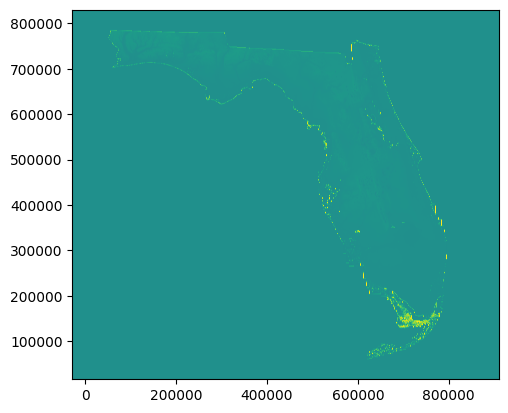

In [36]:
FL_dem = rio.open('../data/FL_DEM/FL_DEM/resampled_reproj_flidar_mosaic_in.tif')
show(FL_dem)

#assigning dataframe as new variable
shp = df1_zhvi

#reading raster datasetReader as an array
array = FL_dem.read(1)
affine = FL_dem.transform

In [37]:
#including nodata in statistics list to know how many pixels are nodata values so that statistics is not incorrect
stats = zonal_stats(shp, 
                    array, 
                    affine=affine, 
                    stats=['mean', 'nodata'],
                   geojson_out=True
                    )
print (type(stats[0]))

C:\Users\aadyab\AppData\Local\anaconda3\envs\env1\lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


<class 'dict'>


In [38]:
#extracting zonal stats only from the stats dictionary
mean_ele =  []

i = 0

while i < len(stats):
    mean_ele.append((stats[i]['properties']))
    i = i + 1

In [39]:
#creating dataframe from mean elevation
df = pd.DataFrame(mean_ele)
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Shape_Leng,Shape_Area,1in100,1in500,%Change,mean,nodata
0,73221,80,34787,zip,FL,FL,Winter Garden,"Orlando-Kissimmee-Sanford, FL",177263.267129,187643.480413,201223.320205,215354.008392,240804.785914,301062.446501,383426.864196,379847.503394,312856.581220,237040.293736,207987.791511,192163.891302,194907.515570,225620.583412,265467.843769,284071.020341,301703.295696,317279.663610,336767.663471,362629.331745,384242.676969,441157.217430,546216.226622,553544.350791,1.145243,0.018612,0.174195,0.219499,2.122725,1230.432775,0.0
1,72362,96,33024,zip,FL,FL,Pembroke Pines,"Miami-Fort Lauderdale-Pompano Beach, FL",95537.304993,108702.206559,124185.919386,139790.268667,163857.909835,205683.131541,251764.265875,253794.935348,200817.126138,143575.945011,131565.666263,121491.664476,126801.369978,149960.265712,175041.638674,197509.653576,221028.288873,249445.718620,274301.429368,290352.267248,308487.613036,347410.141244,407862.981147,424388.837688,0.249723,0.002777,0.234319,0.422797,3.442127,236.940559,0.0
2,72530,133,33311,zip,FL,FL,Fort Lauderdale,"Miami-Fort Lauderdale-Pompano Beach, FL",54515.456786,62814.582286,70907.582963,77471.104988,89831.197604,112318.043285,136781.857835,145739.291901,119516.244525,83129.706554,71682.686912,60706.506165,58555.923525,69627.607064,87321.086095,102459.049640,119528.897512,145298.003483,171881.436508,193133.086193,212828.248717,247273.325587,299024.079330,315607.724772,0.251871,0.002465,0.258111,0.433085,4.789326,103.333322,0.0
3,72361,145,33023,zip,FL,FL,Miramar,"Miami-Fort Lauderdale-Pompano Beach, FL",80083.825376,90701.811936,103442.366702,115868.261262,135242.110348,167436.299937,204958.318773,215020.922953,176653.261455,126250.664213,111318.280962,101894.465529,101900.647392,120525.107732,143090.469411,162643.985334,187322.114906,219517.845182,249539.852448,268765.281952,289112.685012,327509.938242,382882.877666,398303.546514,0.239457,0.002093,0.234619,0.422255,3.973583,142.074427,0.0
4,72578,149,33411,zip,FL,FL,None,"Miami-Fort Lauderdale-Pompano Beach, FL",121188.331699,131454.610877,147881.735614,170471.071814,203954.143763,257885.132880,307094.337425,284740.843805,228694.481712,183239.388321,166952.262721,152492.785203,148503.083351,170190.526392,203451.330663,226601.429539,252266.056058,272725.111759,291440.045873,303474.964079,317310.946182,365624.760036,440075.865111,447611.669489,0.545057,0.008506,0.406732,0.582441,2.693521,185.784966,0.0


In [40]:
#merging meanelevation into zipcode geodataframe
df1_zhvi = pd.merge(df1_zhvi, df[['RegionName','mean']], on ='RegionName', how='left')
df1_zhvi.rename(columns={"mean": "meanEle"}, inplace = True)
#df1_zhvi['RegionName'] = df1_zhvi['RegionName'].astype('int')
df1_zhvi.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Shape_Leng,Shape_Area,1in100,1in500,geometry,%Change,meanEle
0,73221,80,34787,zip,FL,FL,Winter Garden,"Orlando-Kissimmee-Sanford, FL",177263.267129,187643.480413,201223.320205,215354.008392,240804.785914,301062.446501,383426.864196,379847.503394,312856.581220,237040.293736,207987.791511,192163.891302,194907.515570,225620.583412,265467.843769,284071.020341,301703.295696,317279.663610,336767.663471,362629.331745,384242.676969,441157.217430,546216.226622,553544.350791,1.145243,0.018612,0.174195,0.219499,"MULTIPOLYGON (((639845.336 505019.091, 639686....",2.122725,1230.432775
1,72362,96,33024,zip,FL,FL,Pembroke Pines,"Miami-Fort Lauderdale-Pompano Beach, FL",95537.304993,108702.206559,124185.919386,139790.268667,163857.909835,205683.131541,251764.265875,253794.935348,200817.126138,143575.945011,131565.666263,121491.664476,126801.369978,149960.265712,175041.638674,197509.653576,221028.288873,249445.718620,274301.429368,290352.267248,308487.613036,347410.141244,407862.981147,424388.837688,0.249723,0.002777,0.234319,0.422797,"POLYGON ((778192.803 232326.980, 778194.403 23...",3.442127,236.940559
2,72530,133,33311,zip,FL,FL,Fort Lauderdale,"Miami-Fort Lauderdale-Pompano Beach, FL",54515.456786,62814.582286,70907.582963,77471.104988,89831.197604,112318.043285,136781.857835,145739.291901,119516.244525,83129.706554,71682.686912,60706.506165,58555.923525,69627.607064,87321.086095,102459.049640,119528.897512,145298.003483,171881.436508,193133.086193,212828.248717,247273.325587,299024.079330,315607.724772,0.251871,0.002465,0.258111,0.433085,"POLYGON ((784536.755 246245.190, 784537.439 24...",4.789326,103.333322
3,72361,145,33023,zip,FL,FL,Miramar,"Miami-Fort Lauderdale-Pompano Beach, FL",80083.825376,90701.811936,103442.366702,115868.261262,135242.110348,167436.299937,204958.318773,215020.922953,176653.261455,126250.664213,111318.280962,101894.465529,101900.647392,120525.107732,143090.469411,162643.985334,187322.114906,219517.845182,249539.852448,268765.281952,289112.685012,327509.938242,382882.877666,398303.546514,0.239457,0.002093,0.234619,0.422255,"POLYGON ((782275.929 226797.116, 782287.615 22...",3.973583,142.074427
4,72578,149,33411,zip,FL,FL,NaN,"Miami-Fort Lauderdale-Pompano Beach, FL",121188.331699,131454.610877,147881.735614,170471.071814,203954.143763,257885.132880,307094.337425,284740.843805,228694.481712,183239.388321,166952.262721,152492.785203,148503.083351,170190.526392,203451.330663,226601.429539,252266.056058,272725.111759,291440.045873,303474.964079,317310.946182,365624.760036,440075.865111,447611.669489,0.545057,0.008506,0.406732,0.582441,"POLYGON ((783714.960 311202.948, 783714.419 31...",2.693521,185.784966


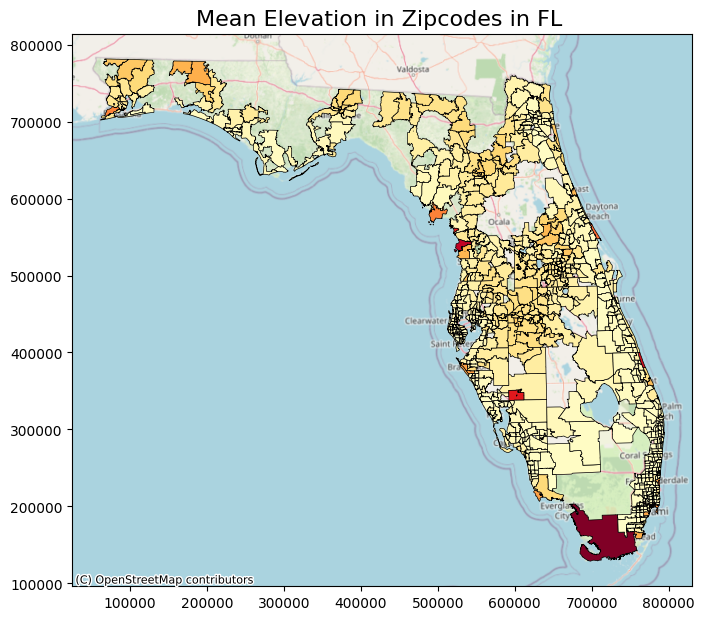

In [41]:
#plotting zipcode wise mean elevation 
ax4 = df1_zhvi.plot(column = 'meanEle', cmap = 'YlOrRd', linewidth= 0.5, edgecolor='k', figsize=(8,8))
cx.add_basemap(ax4, source=xyz.OpenStreetMap.Mapnik, crs=df1_zhvi.crs)
ax4.set_title('Mean Elevation in Zipcodes in FL ',  fontdict={'fontsize': '16', 'fontweight' : '1'})
plt.savefig('../data/exportedMaps/MeanElevationZipcodes.pdf')

In [46]:
#### Combining all data into single geodataframe
final_zhvi = pd.merge(df1_zhvi,zhvi_w_coastline[['RegionName','distances']],on='RegionName', how='left')
final_zhvi.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Shape_Leng,Shape_Area,1in100,1in500,geometry,%Change,meanEle,distances
0,73221,80,34787,zip,FL,FL,Winter Garden,"Orlando-Kissimmee-Sanford, FL",177263.267129,187643.480413,201223.320205,215354.008392,240804.785914,301062.446501,383426.864196,379847.503394,312856.581220,237040.293736,207987.791511,192163.891302,194907.515570,225620.583412,265467.843769,284071.020341,301703.295696,317279.663610,336767.663471,362629.331745,384242.676969,441157.217430,546216.226622,553544.350791,1.145243,0.018612,0.174195,0.219499,"MULTIPOLYGON (((639845.336 505019.091, 639686....",2.122725,1230.432775,92775.538551
1,72362,96,33024,zip,FL,FL,Pembroke Pines,"Miami-Fort Lauderdale-Pompano Beach, FL",95537.304993,108702.206559,124185.919386,139790.268667,163857.909835,205683.131541,251764.265875,253794.935348,200817.126138,143575.945011,131565.666263,121491.664476,126801.369978,149960.265712,175041.638674,197509.653576,221028.288873,249445.718620,274301.429368,290352.267248,308487.613036,347410.141244,407862.981147,424388.837688,0.249723,0.002777,0.234319,0.422797,"POLYGON ((778192.803 232326.980, 778194.403 23...",3.442127,236.940559,13021.360223
2,72530,133,33311,zip,FL,FL,Fort Lauderdale,"Miami-Fort Lauderdale-Pompano Beach, FL",54515.456786,62814.582286,70907.582963,77471.104988,89831.197604,112318.043285,136781.857835,145739.291901,119516.244525,83129.706554,71682.686912,60706.506165,58555.923525,69627.607064,87321.086095,102459.049640,119528.897512,145298.003483,171881.436508,193133.086193,212828.248717,247273.325587,299024.079330,315607.724772,0.251871,0.002465,0.258111,0.433085,"POLYGON ((784536.755 246245.190, 784537.439 24...",4.789326,103.333322,7071.177737
3,72361,145,33023,zip,FL,FL,Miramar,"Miami-Fort Lauderdale-Pompano Beach, FL",80083.825376,90701.811936,103442.366702,115868.261262,135242.110348,167436.299937,204958.318773,215020.922953,176653.261455,126250.664213,111318.280962,101894.465529,101900.647392,120525.107732,143090.469411,162643.985334,187322.114906,219517.845182,249539.852448,268765.281952,289112.685012,327509.938242,382882.877666,398303.546514,0.239457,0.002093,0.234619,0.422255,"POLYGON ((782275.929 226797.116, 782287.615 22...",3.973583,142.074427,9509.542271
4,72578,149,33411,zip,FL,FL,NaN,"Miami-Fort Lauderdale-Pompano Beach, FL",121188.331699,131454.610877,147881.735614,170471.071814,203954.143763,257885.132880,307094.337425,284740.843805,228694.481712,183239.388321,166952.262721,152492.785203,148503.083351,170190.526392,203451.330663,226601.429539,252266.056058,272725.111759,291440.045873,303474.964079,317310.946182,365624.760036,440075.865111,447611.669489,0.545057,0.008506,0.406732,0.582441,"POLYGON ((783714.960 311202.948, 783714.419 31...",2.693521,185.784966,16765.086881


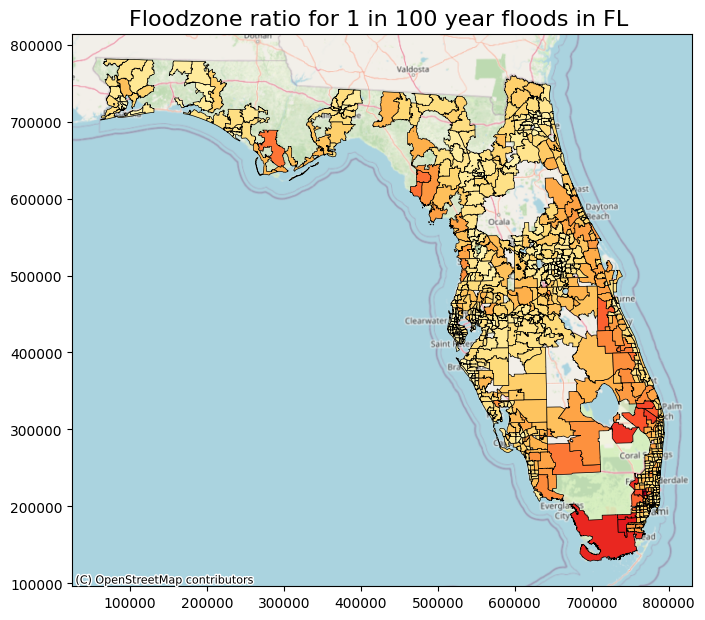

In [47]:
#plotting 1 in 100  floodzone ratio in zipcodes
ax5 = df1_zhvi.plot(column = '1in100', cmap = 'YlOrRd', linewidth= 0.5, edgecolor='k', figsize=(8,8))
cx.add_basemap(ax5, source=xyz.OpenStreetMap.Mapnik, crs=df1_zhvi.crs)
ax5.set_title('Floodzone ratio for 1 in 100 year floods in FL ',  fontdict={'fontsize': '16', 'fontweight' : '1'})
plt.savefig('../data/exportedMaps/FZ1in100_Zipcode.pdf')

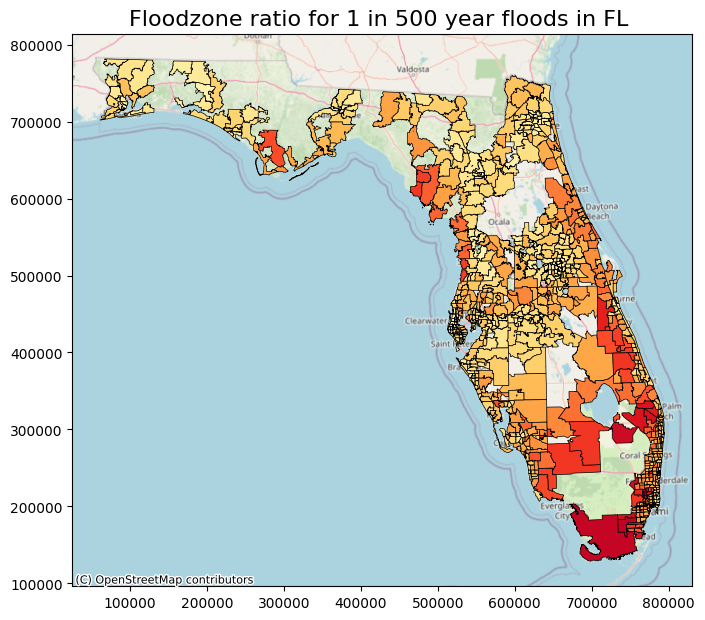

In [48]:
#plotting 1 in 500  floodzone ratio in zipcodes
ax6 = df1_zhvi.plot(column = '1in500', cmap = 'YlOrRd', linewidth= 0.5, edgecolor='k', figsize=(8,8))
cx.add_basemap(ax6, source=xyz.OpenStreetMap.Mapnik, crs=df1_zhvi.crs)
ax6.set_title('Floodzone ratio for 1 in 500 year floods in FL ',  fontdict={'fontsize': '16', 'fontweight' : '1'})
plt.savefig('../data/exportedMaps/FZ1in500_Zipcode.pdf')

In [49]:
# exporting zillow home value index to shapefile to calculate flood ratio
final_zhvi.to_file('../data/finalFiles/zipcode_final.shp')